## EDA

In [2]:
import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import sys
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pandas as pd
from multiprocessing import Process# this is used for multithreading
import multiprocessing
import codecs# this is used for file operations 
import random as r
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

### CSV 파일로 변환

In [1]:
import os
import glob

files = glob.glob("./*/*.asm")
for name in files:
  if not os.path.isdir(name):
    src = os.path.splitext(name)
    os.rename(name,src[0]+'.csv')

### OPCODE 분포도 확인

In [3]:
# Train Benign
file_list = []
for x in glob.glob('./train__benign/*.csv'):
  file_list.append(x)
  
file_list.sort()
train_benign_df = pd.DataFrame()

In [4]:
# opcode 종류 확인을 위한 opcode 띄워놓기
import csv

opcode_list = []
f = open('./data/train_benign/0a4dda202e8b95a440fc58fcb5e36adf.csv', 'r')
rdr = csv.reader(f)
for line in rdr:
  opcode_list.append(line[0][:7].strip())
f.close()

<AxesSubplot:xlabel='opcode'>

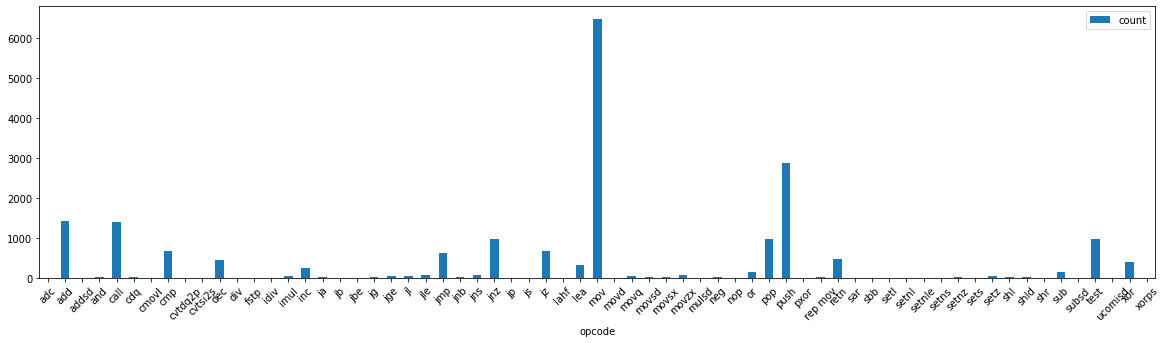

In [5]:
# train_benign 무작위 한 개의 경우
np_array = np.array(opcode_list)
unique, counts = np.unique(np_array, return_counts=True)

result = np.column_stack((unique, counts))
result_df = pd.DataFrame(result)
result_df.columns = ['opcode', 'count']
result_df = result_df.astype({'count':'int'})

import matplotlib.pyplot as plt
%matplotlib inline
result_df.plot.bar(x='opcode', y='count',figsize=(20, 5) ,rot=45)

In [6]:
# train_benign opcode 리스트화
opcodes = set(opcode_list)
print(opcodes)

{'cvtsi2s', 'jmp', 'and', 'shl', 'retn', 'setnle', 'mulsd', 'setnl', 'subsd', 'cmovl', 'push', 'setl', 'add', 'jle', 'movzx', 'ucomisd', 'sbb', 'test', 'idiv', 'setns', 'imul', 'shld', 'movd', 'jg', 'pop', 'neg', 'cdq', 'jp', 'rep mov', 'fstp', 'cmp', 'jge', 'setz', 'sets', 'jbe', 'ja', 'xor', 'inc', 'setnz', 'jnb', 'addsd', 'pxor', 'jz', 'mov', 'lea', 'js', 'lahf', 'jns', 'shr', 'sub', 'dec', 'sar', 'adc', 'jnz', 'movsd', 'movq', 'jb', 'nop', 'jl', 'or', 'call', 'cvtdq2p', 'div', 'xorps', 'movsx'}


In [7]:
# train_malware 무작위 한 개의 경우
opcode_list = []
f = open('./data/train_malware/0a0db35480d28e33833181775536f85e.csv', 'r')
rdr = csv.reader(f)
for line in rdr:
  opcode_list.append(line[0][:7].strip())
f.close()

<AxesSubplot:xlabel='opcode'>

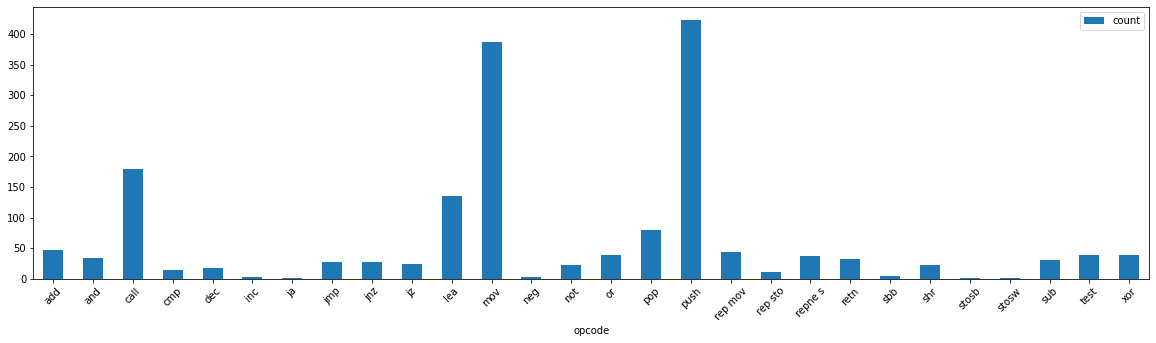

In [8]:
# 정상 파일 한 개의 경우
np_array = np.array(opcode_list)
unique, counts = np.unique(np_array, return_counts=True)

result = np.column_stack((unique, counts))
result_df = pd.DataFrame(result)
result_df.columns = ['opcode', 'count']
result_df = result_df.astype({'count':'int'})

import matplotlib.pyplot as plt
%matplotlib inline
result_df.plot.bar(x='opcode', y='count',figsize=(20, 5) ,rot=45)

In [9]:
# # 모든 정상 파일의 경우
# import time
# from tqdm import tqdm

# train_benign_df = pd.concat([pd.read_csv(file, sep='\t') for file in tqdm(file_list)], axis=0)
# train_benign_df
# # train_benign_df.to_csv("./csv_files/test_benign.csv")

In [10]:
# train_malware opcode 확인

opcodes = set(opcode_list)
print(opcodes)

{'jmp', 'and', 'retn', 'stosw', 'push', 'add', 'sbb', 'test', 'pop', 'neg', 'rep mov', 'cmp', 'repne s', 'ja', 'xor', 'inc', 'jz', 'mov', 'shr', 'lea', 'sub', 'dec', 'not', 'jnz', 'stosb', 'or', 'call', 'rep sto'}


In [11]:
# train_benign 파일 개수
import os
def get_files_count(folder_path):
  dirListing = os.listdir(folder_path)
  return len(dirListing)
	
if __name__ == "__main__":
	print(get_files_count("./data/train_benign"))


1000


저 train_benign에 있는 모든 opcode를 쓰자니 malware에 없는 opcode가 다수 존재했으며, 가장 성능이 좋게하기 위해 자주 사용되는 opcode를 선별하여 사용하기로 함.

In [16]:
import time
from tqdm import tqdm

def train_benign_preprocessing(train_benign_bigramsset, train_benign_trigramsset, train_benign_fourgramsset):
  # 선별된 가장 의미 있는 opcodes
  # https://en.wikipedia.org/wiki/X86_instruction_listings
  opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
  # 다른 모듈이나 라이브러리를 참조하거나 불러오는 키워드를 추가적으로 사용하기 위한 배열 생성
  keywords = ['.dll', 'std::', ':dword']
  # 어떤 작업을 수행하기 위해 사용되는 레지스터들, 그리고 특별한 기능을 위한 레지스터들을 사용학 위한 배열 생성
  registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']

  file1 = open("./csv_files/train_benign_asmfile.txt", 'w+')
  opcodefile = open('./output/train_benign_opcode.txt', 'w+')
  files = os.listdir('./data/train_benign')

  for f in tqdm(files):
    opcodescount=np.zeros(len(opcodes),dtype=int)
    keywordcount=np.zeros(len(keywords),dtype=int)
    registerscount=np.zeros(len(registers),dtype=int)
    features=[]
    # 확장자 제거
    f2 = f[:-4]
    file1.write(f2+",")
    opcodefile.write(f2+" ")
    
    with codecs.open('./data/train_benign/' + f, encoding='cp1252', errors='replace') as fli:
      for lines in fli:
        line = lines.rstrip().split()
        for i in range(len(opcodes)):
          if any(opcodes[i]==li for li in line):
            features.append(opcodes[i])
            opcodescount[i] += 1
        for i in range(len(registers)):
          for li in line:
            if registers[i] in li and ('text' in li or 'CODE' in li):
              registerscount[i] += 1
        for i in range(len(keywords)):
          for li in line:
            if keywords[i] in li:
              keywordcount[i] += 1
              
    for opcode in opcodescount:
      file1.write(str(opcode)+",")
    for register in registerscount:
      file1.write(str(register)+",")
    for key in keywordcount:
      file1.write(str(key)+",")
    file1.write("\n")
    for feature in features:
      opcodefile.write(str(feature)+" ")
    opcodefile.write("\n")
    
    for i in range(len(features)):
      if i < len(features) - 1:
        train_benign_bigramsset[features[i]+features[i+1]]=1
      if i < len(features) - 2:
        train_benign_trigramsset[features[i]+features[i+1]+features[i+2]]=1
      if i < len(features) - 3:
        train_benign_fourgramsset[features[i]+features[i+1]+features[i+2]+features[i+3]]=1
  file1.close()
  opcodefile.close()
  
def train_malware_preprocessing(train_malware_bigramsset, train_malware_trigramsset, train_malware_fourgramsset):
  # 선별된 가장 의미 있는 opcodes
  # https://en.wikipedia.org/wiki/X86_instruction_listings
  opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
  # 다른 모듈이나 라이브러리를 참조하거나 불러오는 키워드를 추가적으로 사용하기 위한 배열 생성
  keywords = ['.dll', 'std::', ':dword']
  # 어떤 작업을 수행하기 위해 사용되는 레지스터들, 그리고 특별한 기능을 위한 레지스터들을 사용학 위한 배열 생성
  registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']

  file1 = open("./csv_files/train_malware_asmfile.txt", 'w+')
  opcodefile = open('./output/train_malware_opcode.txt', 'w+')
  files = os.listdir('./data/train_malware')

  for f in tqdm(files):
    opcodescount=np.zeros(len(opcodes),dtype=int)
    keywordcount=np.zeros(len(keywords),dtype=int)
    registerscount=np.zeros(len(registers),dtype=int)
    features=[]
    # 확장자 제거
    f2 = f[:-4]
    file1.write(f2+",")
    opcodefile.write(f2+" ")
    
    with codecs.open('./data/train_malware/' + f, encoding='cp1252', errors='replace') as fli:
      for lines in fli:
        line = lines.rstrip().split()
        for i in range(len(opcodes)):
          if any(opcodes[i]==li for li in line):
            features.append(opcodes[i])
            opcodescount[i] += 1
        for i in range(len(registers)):
          for li in line:
            if registers[i] in li and ('text' in li or 'CODE' in li):
              registerscount[i] += 1
        for i in range(len(keywords)):
          for li in line:
            if keywords[i] in li:
              keywordcount[i] += 1
              
    for opcode in opcodescount:
      file1.write(str(opcode)+",")
    for register in registerscount:
      file1.write(str(register)+",")
    for key in keywordcount:
      file1.write(str(key)+",")
    file1.write("\n")
    for feature in features:
      opcodefile.write(str(feature)+" ")
    opcodefile.write("\n")
    
    for i in range(len(features)):
      if i < len(features) - 1:
        train_malware_bigramsset[features[i]+features[i+1]]=1
      if i < len(features) - 2:
        train_malware_trigramsset[features[i]+features[i+1]+features[i+2]]=1
      if i < len(features) - 3:
        train_malware_fourgramsset[features[i]+features[i+1]+features[i+2]+features[i+3]]=1
  file1.close()
  opcodefile.close()
  
def test_benign_preprocessing(test_benign_bigramsset, test_benign_trigramsset, test_benign_fourgramsset):
  # 선별된 가장 의미 있는 opcodes
  # https://en.wikipedia.org/wiki/X86_instruction_listings
  opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
  # 다른 모듈이나 라이브러리를 참조하거나 불러오는 키워드를 추가적으로 사용하기 위한 배열 생성
  keywords = ['.dll', 'std::', ':dword']
  # 어떤 작업을 수행하기 위해 사용되는 레지스터들, 그리고 특별한 기능을 위한 레지스터들을 사용학 위한 배열 생성
  registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']

  file1 = open("./csv_files/test_benign_asmfile.txt", 'w+')
  opcodefile = open('./output/test_benign_opcode.txt', 'w+')
  files = os.listdir('./data/test_benign')

  for f in tqdm(files):
    opcodescount=np.zeros(len(opcodes),dtype=int)
    keywordcount=np.zeros(len(keywords),dtype=int)
    registerscount=np.zeros(len(registers),dtype=int)
    features=[]
    # 확장자 제거
    f2 = f[:-4]
    file1.write(f2+",")
    opcodefile.write(f2+" ")
    
    with codecs.open('./data/test_benign/' + f, encoding='cp1252', errors='replace') as fli:
      for lines in fli:
        line = lines.rstrip().split()
        for i in range(len(opcodes)):
          if any(opcodes[i]==li for li in line):
            features.append(opcodes[i])
            opcodescount[i] += 1
        for i in range(len(registers)):
          for li in line:
            if registers[i] in li and ('text' in li or 'CODE' in li):
              registerscount[i] += 1
        for i in range(len(keywords)):
          for li in line:
            if keywords[i] in li:
              keywordcount[i] += 1
              
    for opcode in opcodescount:
      file1.write(str(opcode)+",")
    for register in registerscount:
      file1.write(str(register)+",")
    for key in keywordcount:
      file1.write(str(key)+",")
    file1.write("\n")
    for feature in features:
      opcodefile.write(str(feature)+" ")
    opcodefile.write("\n")
    
    for i in range(len(features)):
      if i < len(features) - 1:
        test_benign_bigramsset[features[i]+features[i+1]]=1
      if i < len(features) - 2:
        test_benign_trigramsset[features[i]+features[i+1]+features[i+2]]=1
      if i < len(features) - 3:
        test_benign_fourgramsset[features[i]+features[i+1]+features[i+2]+features[i+3]]=1
  file1.close()
  opcodefile.close()
  
def test_malware_preprocessing(test_malware_bigramsset, test_malware_trigramsset, test_malware_fourgramsset):
  # 선별된 가장 의미 있는 opcodes
  # https://en.wikipedia.org/wiki/X86_instruction_listings
  opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
  # 다른 모듈이나 라이브러리를 참조하거나 불러오는 키워드를 추가적으로 사용하기 위한 배열 생성
  keywords = ['.dll', 'std::', ':dword']
  # 어떤 작업을 수행하기 위해 사용되는 레지스터들, 그리고 특별한 기능을 위한 레지스터들을 사용학 위한 배열 생성
  registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']

  file1 = open("./csv_files/test_malware_asmfile.txt", 'w+')
  opcodefile = open('./output/test_malware_opcode.txt', 'w+')
  files = os.listdir('./data/test_malware')

  for f in tqdm(files):
    opcodescount=np.zeros(len(opcodes),dtype=int)
    keywordcount=np.zeros(len(keywords),dtype=int)
    registerscount=np.zeros(len(registers),dtype=int)
    features=[]
    # 확장자 제거
    f2 = f[:-4]
    file1.write(f2+",")
    opcodefile.write(f2+" ")
    
    with codecs.open('./data/test_malware/' + f, encoding='cp1252', errors='replace') as fli:
      for lines in fli:
        line = lines.rstrip().split()
        for i in range(len(opcodes)):
          if any(opcodes[i]==li for li in line):
            features.append(opcodes[i])
            opcodescount[i] += 1
        for i in range(len(registers)):
          for li in line:
            if registers[i] in li and ('text' in li or 'CODE' in li):
              registerscount[i] += 1
        for i in range(len(keywords)):
          for li in line:
            if keywords[i] in li:
              keywordcount[i] += 1
              
    for opcode in opcodescount:
      file1.write(str(opcode)+",")
    for register in registerscount:
      file1.write(str(register)+",")
    for key in keywordcount:
      file1.write(str(key)+",")
    file1.write("\n")
    for feature in features:
      opcodefile.write(str(feature)+" ")
    opcodefile.write("\n")
    
    for i in range(len(features)):
      if i < len(features) - 1:
        test_malware_bigramsset[features[i]+features[i+1]]=1
      if i < len(features) - 2:
        test_malware_trigramsset[features[i]+features[i+1]+features[i+2]]=1
      if i < len(features) - 3:
        test_malware_fourgramsset[features[i]+features[i+1]+features[i+2]+features[i+3]]=1
  file1.close()
  opcodefile.close()
  
def valid_benign_preprocessing(valid_benign_bigramsset, valid_benign_trigramsset, valid_benign_fourgramsset):
  # 선별된 가장 의미 있는 opcodes
  # https://en.wikipedia.org/wiki/X86_instruction_listings
  opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
  # 다른 모듈이나 라이브러리를 참조하거나 불러오는 키워드를 추가적으로 사용하기 위한 배열 생성
  keywords = ['.dll', 'std::', ':dword']
  # 어떤 작업을 수행하기 위해 사용되는 레지스터들, 그리고 특별한 기능을 위한 레지스터들을 사용학 위한 배열 생성
  registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']

  file1 = open("./csv_files/valid_benign_asmfile.txt", 'w+')
  opcodefile = open('./output/valid_benign_opcode.txt', 'w+')
  files = os.listdir('./data/valid_benign')

  for f in tqdm(files):
    opcodescount=np.zeros(len(opcodes),dtype=int)
    keywordcount=np.zeros(len(keywords),dtype=int)
    registerscount=np.zeros(len(registers),dtype=int)
    features=[]
    # 확장자 제거
    f2 = f[:-4]
    file1.write(f2+",")
    opcodefile.write(f2+" ")
    
    with codecs.open('./data/valid_benign/' + f, encoding='cp1252', errors='replace') as fli:
      for lines in fli:
        line = lines.rstrip().split()
        for i in range(len(opcodes)):
          if any(opcodes[i]==li for li in line):
            features.append(opcodes[i])
            opcodescount[i] += 1
        for i in range(len(registers)):
          for li in line:
            if registers[i] in li and ('text' in li or 'CODE' in li):
              registerscount[i] += 1
        for i in range(len(keywords)):
          for li in line:
            if keywords[i] in li:
              keywordcount[i] += 1
              
    for opcode in opcodescount:
      file1.write(str(opcode)+",")
    for register in registerscount:
      file1.write(str(register)+",")
    for key in keywordcount:
      file1.write(str(key)+",")
    file1.write("\n")
    for feature in features:
      opcodefile.write(str(feature)+" ")
    opcodefile.write("\n")
    
    for i in range(len(features)):
      if i < len(features) - 1:
        valid_benign_bigramsset[features[i]+features[i+1]]=1
      if i < len(features) - 2:
        valid_benign_trigramsset[features[i]+features[i+1]+features[i+2]]=1
      if i < len(features) - 3:
        valid_benign_fourgramsset[features[i]+features[i+1]+features[i+2]+features[i+3]]=1
  file1.close()
  opcodefile.close()
  
def valid_malware_preprocessing(valid_malware_bigramsset, valid_malware_trigramsset, valid_malware_fourgramsset):
  # 선별된 가장 의미 있는 opcodes
  # https://en.wikipedia.org/wiki/X86_instruction_listings
  opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
  # 다른 모듈이나 라이브러리를 참조하거나 불러오는 키워드를 추가적으로 사용하기 위한 배열 생성
  keywords = ['.dll', 'std::', ':dword']
  # 어떤 작업을 수행하기 위해 사용되는 레지스터들, 그리고 특별한 기능을 위한 레지스터들을 사용학 위한 배열 생성
  registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']

  file1 = open("./csv_files/valid_malware_asmfile.txt", 'w+')
  opcodefile = open('./output/valid_malware_opcode.txt', 'w+')
  files = os.listdir('./data/valid_malware')

  for f in tqdm(files):
    opcodescount=np.zeros(len(opcodes),dtype=int)
    keywordcount=np.zeros(len(keywords),dtype=int)
    registerscount=np.zeros(len(registers),dtype=int)
    features=[]
    # 확장자 제거
    f2 = f[:-4]
    file1.write(f2+",")
    opcodefile.write(f2+" ")
    
    with codecs.open('./data/valid_malware/' + f, encoding='cp1252', errors='replace') as fli:
      for lines in fli:
        line = lines.rstrip().split()
        for i in range(len(opcodes)):
          if any(opcodes[i]==li for li in line):
            features.append(opcodes[i])
            opcodescount[i] += 1
        for i in range(len(registers)):
          for li in line:
            if registers[i] in li and ('text' in li or 'CODE' in li):
              registerscount[i] += 1
        for i in range(len(keywords)):
          for li in line:
            if keywords[i] in li:
              keywordcount[i] += 1
              
    for opcode in opcodescount:
      file1.write(str(opcode)+",")
    for register in registerscount:
      file1.write(str(register)+",")
    for key in keywordcount:
      file1.write(str(key)+",")
    file1.write("\n")
    for feature in features:
      opcodefile.write(str(feature)+" ")
    opcodefile.write("\n")
    
    for i in range(len(features)):
      if i < len(features) - 1:
        valid_malware_bigramsset[features[i]+features[i+1]]=1
      if i < len(features) - 2:
        valid_malware_trigramsset[features[i]+features[i+1]+features[i+2]]=1
      if i < len(features) - 3:
        valid_malware_fourgramsset[features[i]+features[i+1]+features[i+2]+features[i+3]]=1
  file1.close()
  opcodefile.close()

In [17]:
def main():
  manager = multiprocessing.Manager()
  train_benign_bigramsset=manager.dict()
  train_benign_trigramsset=manager.dict()
  train_benign_fourgramsset=manager.dict()
  p1 = Process(target=train_benign_preprocessing, args=(train_benign_bigramsset, train_benign_trigramsset, train_benign_fourgramsset))
  train_malware_bigramsset=manager.dict()
  train_malware_trigramsset=manager.dict()
  train_malware_fourgramsset=manager.dict()
  p2 = Process(target=train_malware_preprocessing, args=(train_malware_bigramsset, train_malware_trigramsset, train_malware_fourgramsset))
  test_benign_bigramsset=manager.dict()
  test_benign_trigramsset=manager.dict()
  test_benign_fourgramsset=manager.dict()
  p3 = Process(target=test_benign_preprocessing, args=(test_benign_bigramsset, test_benign_trigramsset, test_benign_fourgramsset))
  test_malware_bigramsset=manager.dict()
  test_malware_trigramsset=manager.dict()
  test_malware_fourgramsset=manager.dict()
  p4 = Process(target=test_malware_preprocessing, args=(test_malware_bigramsset, test_malware_trigramsset, test_malware_fourgramsset))
  valid_benign_bigramsset=manager.dict()
  valid_benign_trigramsset=manager.dict()
  valid_benign_fourgramsset=manager.dict()
  p5 = Process(target=valid_benign_preprocessing, args=(valid_benign_bigramsset, valid_benign_trigramsset, valid_benign_fourgramsset))
  valid_malware_bigramsset=manager.dict()
  valid_malware_trigramsset=manager.dict()
  valid_malware_fourgramsset=manager.dict()
  p6 = Process(target=valid_malware_preprocessing, args=(valid_malware_bigramsset, valid_malware_trigramsset, valid_malware_fourgramsset))
  

  p1.start()
  p2.start()
  p3.start()
  p4.start()
  p5.start()
  p6.start()
  
  p1.join()
  p2.join()
  p3.join()
  p4.join()
  p5.join()
  p6.join()
  
  
  
if __name__=="__main__":
  main()

100%|██████████| 1000/1000 [6:19:23<00:00, 22.76s/it]   


#### opcode의 경우 다음과 같이 저장됨
![nn](./image/KakaoTalk_20220530_211103357.png)


### TSNE 분석

In [41]:
# train_benign 데이터프레임화 하기
import pandas as pd
train_benign_df = pd.read_csv("./csv_files/train_benign_asmfile.txt")
train_benign_df.drop(train_benign_df.columns[-1], axis=1, inplace=True)
train_benign_df.set_axis(['ID', 'jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx', 'edx','esi','eax','ebx','ecx','edi','ebp','esp','eip', '.dll', 'std::', ':dword'], axis='columns', inplace=True)
train_benign_df['label'] = 0
train_benign_df.head()

,ID,jmp,mov,retf,push,pop,xor,retn,nop,sub,...,ebx,ecx,edi,ebp,esp,eip,.dll,std::,:dword,label
0,4d1bbe1ef6371b338826836d740d726f,2473,25391,0,11703,3486,2544,1724,25,1304,...,0,0,0,0,0,0,2,367,113,0
1,0d2b28bec8d17f692db56e87cce59992,520,4692,0,5653,1239,453,520,0,274,...,0,0,0,1,1,0,7,0,17,0
2,4df4d08911a65aa83284545ca1ffeb71,294,2016,0,2579,711,348,271,6,165,...,0,0,0,0,0,0,7,0,7,0
3,1ed70ce407ad8203816829b4ea1aae3d,289,1306,0,1992,170,127,77,0,88,...,0,0,0,0,0,0,0,0,0,0
4,2eccffbe627068a60bf7911fd8701ae6,143,1165,0,1107,266,124,159,0,48,...,0,0,0,0,0,0,2,0,0,0


In [39]:
# train_malware 데이터프레임화 하기
train_malware_df = pd.read_csv("./csv_files/train_malware_asmfile.txt")
train_malware_df.drop(train_malware_df.columns[-1], axis=1, inplace=True)
train_malware_df.set_axis(['ID', 'jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx', 'edx','esi','eax','ebx','ecx','edi','ebp','esp','eip', '.dll', 'std::', ':dword'], axis='columns', inplace=True)
train_malware_df['label'] = 1
train_malware_df.head()

,ID,jmp,mov,retf,push,pop,xor,retn,nop,sub,...,ebx,ecx,edi,ebp,esp,eip,.dll,std::,:dword,label
0,1e83041702d866316703a77fcacb558a,86,471,0,248,73,74,64,0,26,...,0,0,0,0,0,0,0,84,0,1
1,2ef324ee0b6960d7e5bc6425b9523b19,280,1387,0,2012,169,127,78,0,111,...,0,0,0,0,0,0,0,0,0,1
2,3c7fc3a1a687f0c303a0e0944e59e5df,1180,15749,1,11070,6019,1326,2152,154,816,...,0,0,0,0,0,0,0,56,7,1
3,3e0d176812b1416f4e399ebe35ba9ca2,82,335,2,689,12,7,9,0,27,...,0,0,0,0,0,0,0,0,0,1
4,2bd568265b715c5b6c056ba79b745869,119,1195,0,368,44,53,30,0,85,...,0,0,0,0,0,0,1,0,0,1


In [56]:
from sklearn.preprocessing import MinMaxScaler
train_benign_tsne = train_benign_df.drop('ID', axis=1)
train_malware_tsne = train_malware_df.drop('ID', axis=1)
scaler = MinMaxScaler()
NORMALIZE_VALID_COLUMNS = [ 'jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx', 'edx','esi','eax','ebx','ecx','edi','ebp','esp','eip', '.dll', 'std::', ':dword']

scaler=MinMaxScaler()
colnames = train_benign_df.columns
new_colnames = [i for i in colnames]
normalized_train_benign_df = pd.concat([train_benign_tsne[NORMALIZE_VALID_COLUMNS], pd.DataFrame(scaler.fit_transform(train_benign_tsne[NORMALIZE_VALID_COLUMNS]), columns=NORMALIZE_VALID_COLUMNS)], axis=1)      
normalized_train_malware_df = pd.concat([train_malware_tsne[NORMALIZE_VALID_COLUMNS], pd.DataFrame(scaler.fit_transform(train_malware_tsne[NORMALIZE_VALID_COLUMNS]), columns=NORMALIZE_VALID_COLUMNS)], axis=1)                                

In [57]:
normalized_train_benign_df['label'] = 0
normalized_train_malware_df['label'] = 1

In [79]:
normalized_train_benign_df

,jmp,mov,retf,push,pop,xor,retn,nop,sub,inc,...,ebx,ecx,edi,ebp,esp,eip,.dll,std::,:dword,label
0,2473,25391,0,11703,3486,2544,1724,25,1304,353,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.016949,0.059414,0.003829,0
1,520,4692,0,5653,1239,453,520,0,274,208,...,0.0,0.0,0.0,0.006944,0.010204,0.0,0.059322,0.000000,0.000576,0
2,294,2016,0,2579,711,348,271,6,165,90,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.059322,0.000000,0.000237,0
3,289,1306,0,1992,170,127,77,0,88,117,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0
4,143,1165,0,1107,266,124,159,0,48,46,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.016949,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,27,892,0,824,125,75,38,0,12,51,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0
995,104,740,0,785,191,94,112,0,17,53,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000034,0
996,6242,73140,0,18460,357,495,1505,24,8349,1203,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.025424,0.000000,0.014942,0
997,335,4360,0,1329,633,393,259,3,482,258,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.042373,0.001133,0.001457,0


In [76]:
tsne_df = pd.concat([normalized_train_benign_df, normalized_train_malware_df], axis=0)
tsne_df

,jmp,mov,retf,push,pop,xor,retn,nop,sub,inc,...,ebx,ecx,edi,ebp,esp,eip,.dll,std::,:dword,label
0,2473,25391,0,11703,3486,2544,1724,25,1304,353,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.016949,0.059414,0.003829,0
1,520,4692,0,5653,1239,453,520,0,274,208,...,0.0,0.0,0.0,0.006944,0.010204,0.0,0.059322,0.000000,0.000576,0
2,294,2016,0,2579,711,348,271,6,165,90,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.059322,0.000000,0.000237,0
3,289,1306,0,1992,170,127,77,0,88,117,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0
4,143,1165,0,1107,266,124,159,0,48,46,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.016949,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,659,5795,0,8979,230,41,159,0,122,29,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.097633,0.000000,0.000000,1
995,1800,22092,0,12995,3569,1518,1519,54,1858,1210,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.056213,0.000000,0.047976,1
996,663,4432,41,1900,638,174,234,0,241,248,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.298351,1
997,1,913,0,12,12,438,0,0,103,0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1


In [64]:
# tsne 분석을 위한 차원축소 (2차원으로 보기 위함)
tsne_np = TSNE(n_components=2).fit_transform(tsne_df)
two_dimension_tsne_df = pd.DataFrame(tsne_np, columns=['component 0', 'component 1'])

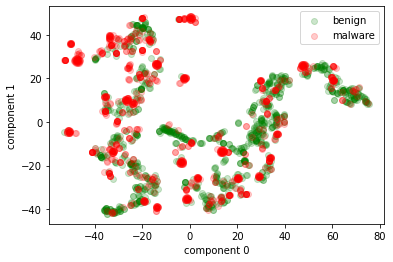

In [85]:
# # label 별 분리
tsne_df_0 = two_dimension_tsne_df.iloc[:998]
tsne_df_1 = two_dimension_tsne_df.iloc[999:]
# #  label 별 시각화
plt.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'], color='green', label='benign', alpha=0.2)
plt.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'], color = 'red', label='malware', alpha=0.2)
# 라벨 이름 붙이기
plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()

### 상관관계 분석

<AxesSubplot:>

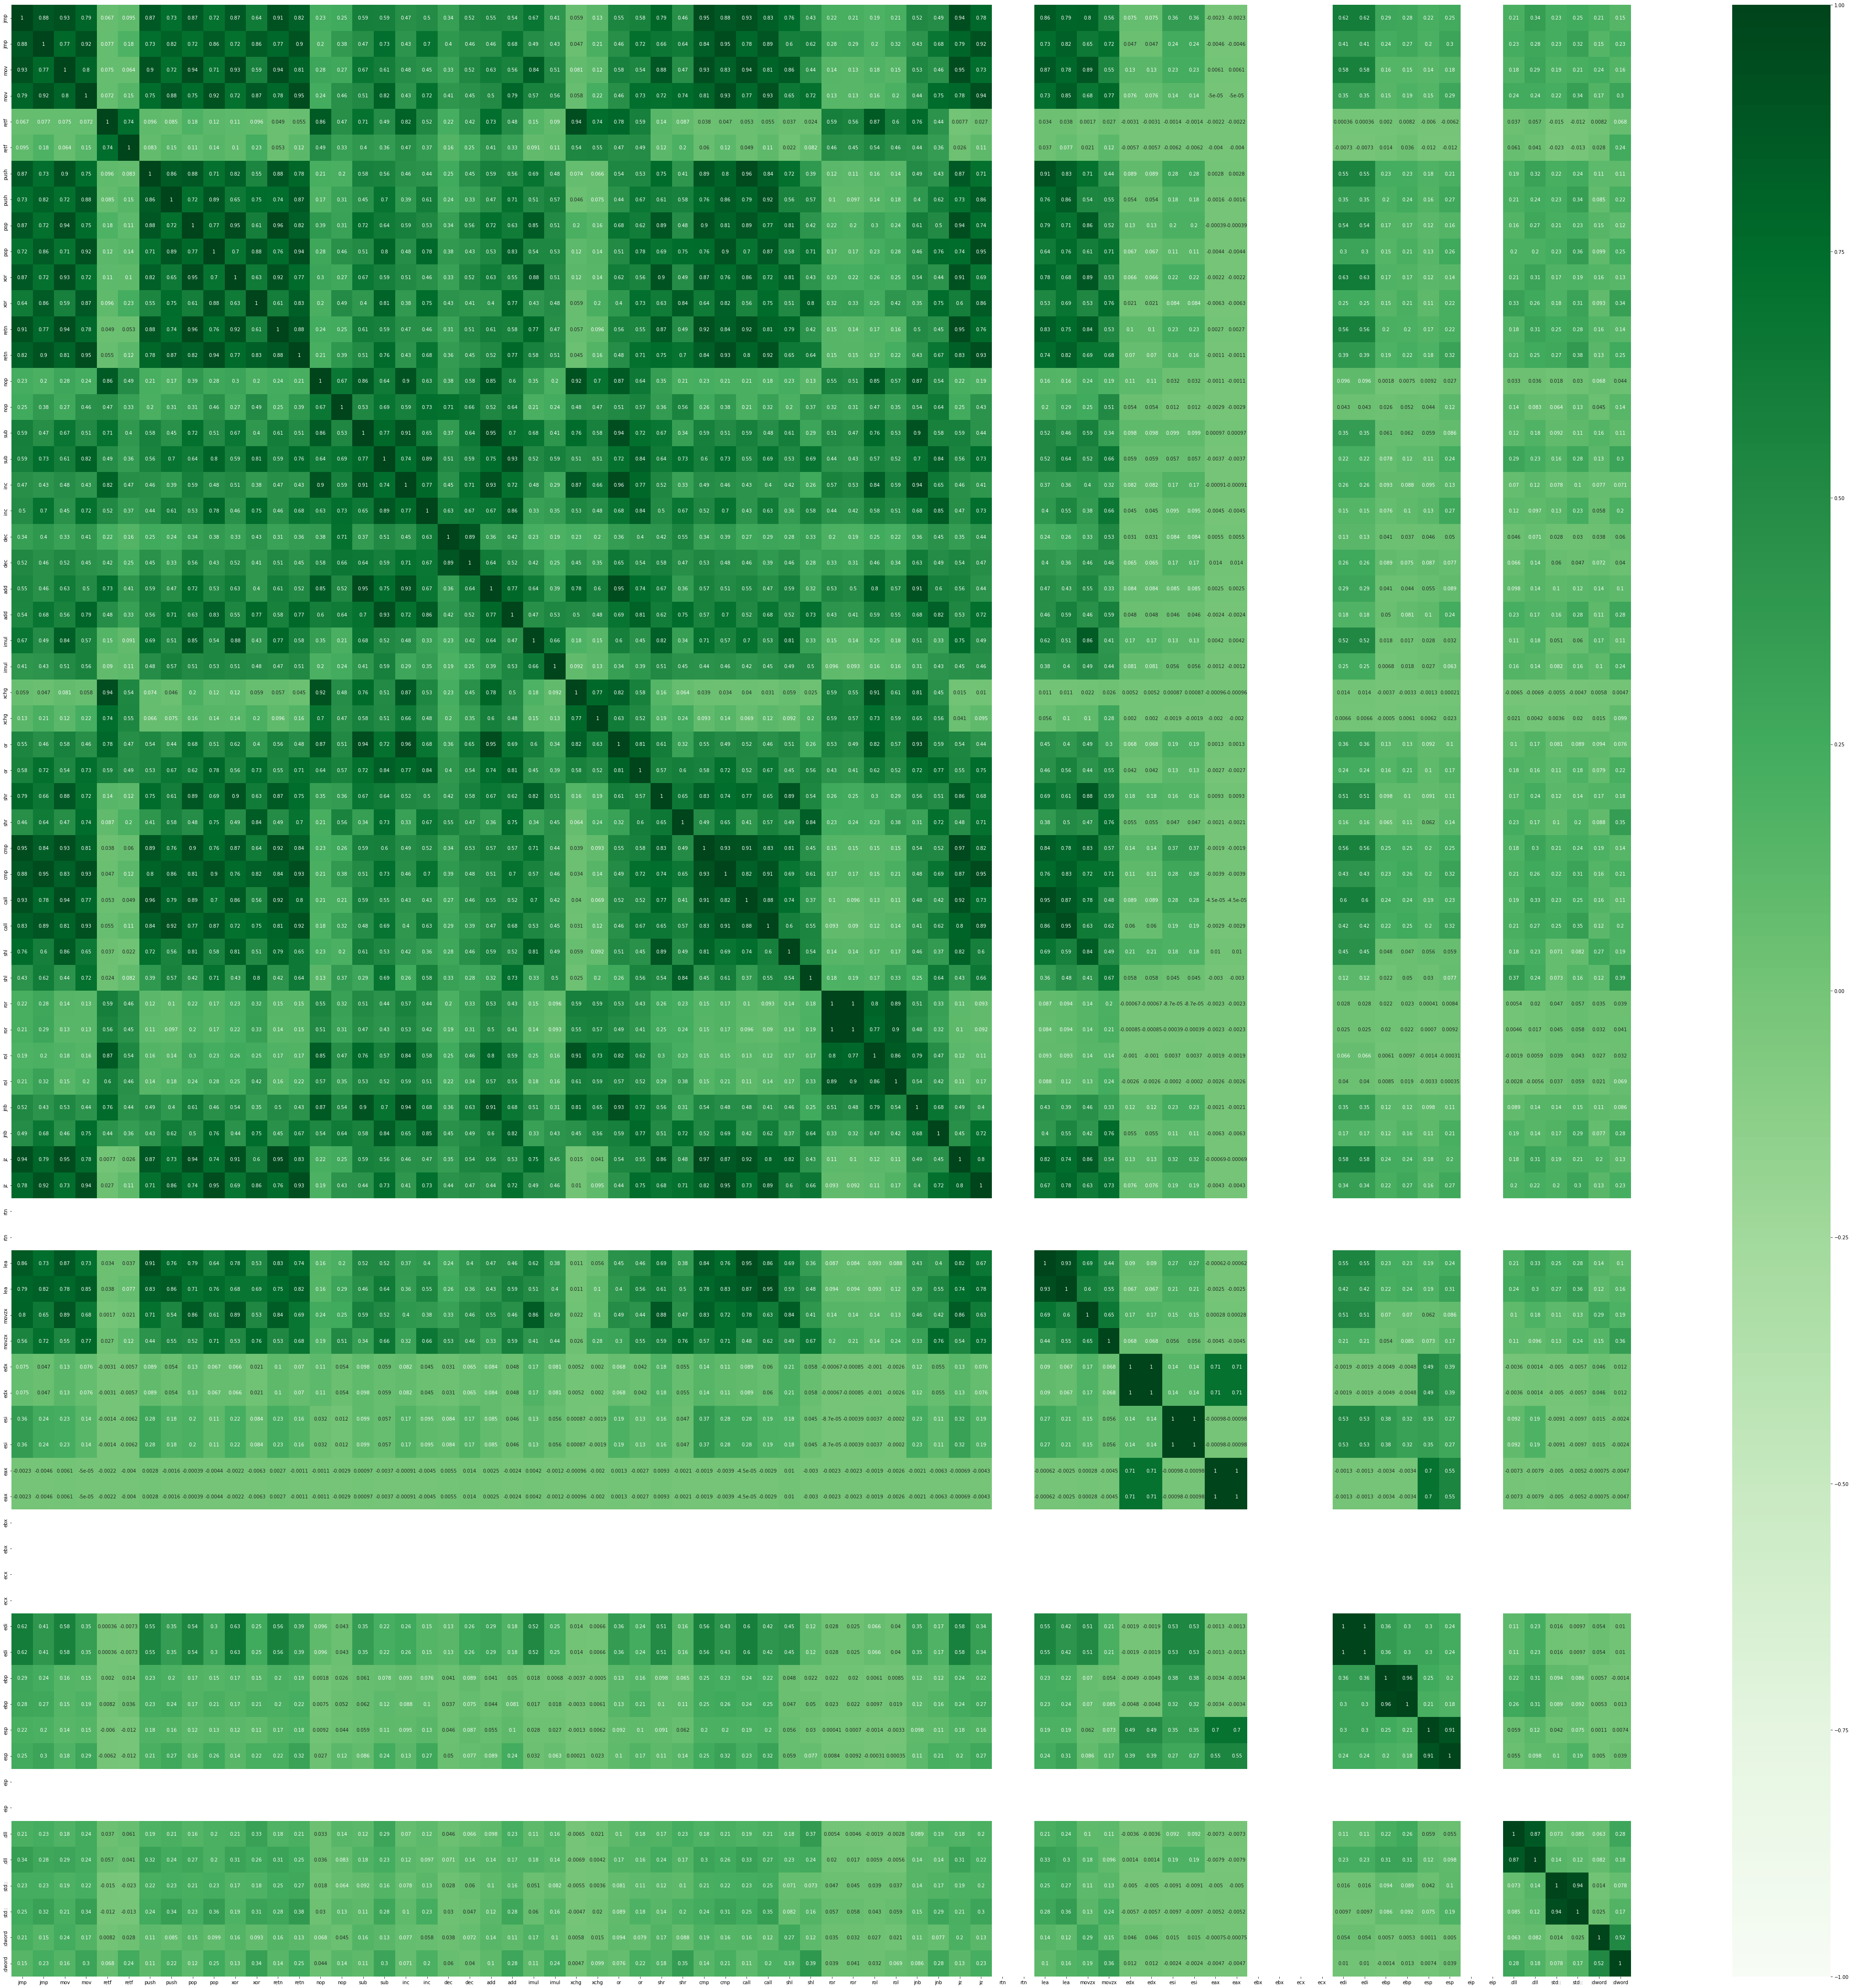

In [86]:
plt.rcParams['figure.figsize'] = (76, 76)
sns.heatmap(tsne_df[NORMALIZE_VALID_COLUMNS].corr(),
            annot = True,
            cmap = 'Greens',
            vmin = -1, vmax=1)